In [1]:
import os
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import random
import timm
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from tqdm.notebook import tqdm
from sklearn.metrics import precision_recall_curve, average_precision_score
from utils.utils import get_device, set_seed

## 設定

In [2]:
pattern_date = '2023-12-24'
root_dir = f'{"/".join(os.getcwd().split("/")[:-1])}'
safetybelt_detection_label_dir = f'{root_dir}/data/outputs/05.safetybelt_detection/00.safetybelt_detection_add_label'
train_result_dir = f'{root_dir}/data/outputs/03.helmet_detection/01.training_coatnet_cls7_use_anno'
result_dir = f'{root_dir}/data/outputs/05.safetybelt_detection/02.eval_coatnet_cls3_use_anno'

In [3]:
annotation_safetybelt_df = pd.read_csv(f'{safetybelt_detection_label_dir}/safetybelt_eval_annotation_add_label-{pattern_date}.csv')
pred_safetybelt_df = pd.read_csv(f'{safetybelt_detection_label_dir}/safetybelt_eval_pred_add_label-{pattern_date}.csv')

In [4]:
class_category = [
    ['detection-miss'],
    ['safetybelt'],
    ['no-safetybelt'],
]
no_alarm_class_category = ['detection-miss', 'safetybelt']

In [5]:
huggingface_model_name = 'coatnet_2_rw_224.sw_in12k_ft_in1k'
input_img_size = 224

In [6]:
# パラメータ
batch_size = 32
seed = 42

## 安全帯分類の推論実行

In [7]:
set_seed(seed=seed)
device = get_device()

In [8]:
class ClassificationDataset(Dataset):
    def __init__(self, df, transform=None, training=False):
        self.df = df
        self.img_paths = [f'{root_dir}/data/images/{path}' for path in df['relative_img_path'].values]
        self.labels = list(df['label_safetybelt'].values)
        self.bboxes = list(df[['left', 'top', 'right', 'bottom']].values)
        self.transform = transform
        self.training = training

    def __getitem__(self, idx):
        image = Image.open(self.img_paths[idx])
        bbox = self.bboxes[idx]
        if self.training:
            bbox_width = bbox[2] - bbox[0]
            bbox_height = bbox[3] - bbox[1]
            img_width, img_height = image.size

            random_ratio = random.uniform(0, 0.2)
            add_bbox_width = bbox_width * random_ratio
            add_bbox_height = bbox_height * random_ratio
            bbox[0] = bbox[0] - add_bbox_width / 2 if bbox[0] - add_bbox_width / 2 > 0 else 0
            bbox[1] = bbox[1] - add_bbox_height / 2 if bbox[1] - add_bbox_height / 2 > 0 else 0
            bbox[2] = bbox[2] + add_bbox_width / 2 if bbox[2] + add_bbox_width / 2 < img_width else img_width
            bbox[3] = bbox[3] + add_bbox_height / 2 if bbox[3] + add_bbox_height / 2 < img_height else img_height

            cropped_image = image.crop(bbox)
        else:
            cropped_image = image.crop(bbox)

        img = np.array(cropped_image)
        augmented = self.transform(image=img)
        image = augmented['image']

        for i, category_names in enumerate(class_category):
            if self.labels[idx] in category_names:
                label = i
        return image, label

    def __len__(self):
        return len(self.df)

In [9]:
A_transforms_val = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

### cross-validationでの評価

In [10]:
labels_list = []
prob_list = []
valid_all_df_list = []
for num_cv in range(3):
    valid_df = pred_safetybelt_df[
        (pred_safetybelt_df['validation'] == num_cv) &
        (
            (pred_safetybelt_df['unique_key'].str.contains('fixed-point-camera')) |
            (pred_safetybelt_df['unique_key'].str.contains('for-learning/2023-11-19-omaezaki-500')) |
            (pred_safetybelt_df['unique_key'].str.contains('for-learning/2023-11-23-mie-safetybelt'))
        )
    ]
    valid_all_df_list.append(valid_df)

    valid_data = ClassificationDataset(valid_df, A_transforms_val)
    valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=False)

    # model
    model = timm.create_model(huggingface_model_name, pretrained=True, num_classes=len(class_category))
    model.load_state_dict(torch.load(f'{train_result_dir}/{num_cv}/model.pth'))
    model.to(device)

    with torch.no_grad():
        for data, label in tqdm(valid_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            probs = F.softmax(val_output, dim=1)
            labels_list.append(label.detach().cpu().numpy())
            prob_list.append(probs.detach().cpu().numpy())
labels_np = np.concatenate(labels_list)
prob_np = np.concatenate(prob_list)
prob_argmax = np.argmax(prob_np, axis=1)
valid_all_df = pd.concat(valid_all_df_list)

/home/kicodevs/.local/share/virtualenvs/crassone-analysis-IVAO5Hrn/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [11]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,safetybelt,no-safetybelt
detection-miss,135,3,67
safetybelt,4,307,31
no-safetybelt,91,24,1343


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [12]:
def pred_class_names_precision095(row):
    no_safetybelt_threshold = row['threshold - no-safetybelt']
    if row['no-safetybelt'] >= no_safetybelt_threshold:
        return 'no-safetybelt'
    return row[no_alarm_class_category].idxmax()

In [13]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
for num_cv in range(3):
    threshold_precision095_valid_dict = {}
    for class_num, class_names in enumerate(class_category):
        if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
            continue
        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        _threshold = 1.0
        for p, t in zip(precisions, thresholds):
            if p >= 0.95:
                _threshold = t
                break
        threshold_precision095_valid_dict[class_names[0]] = _threshold
    threshold_precision095_df_list.append(pd.DataFrame(
        [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(valid_all_df[valid_all_df['validation'] == num_cv]))],
        columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
    ))
threshold_precision095_df = pd.concat(threshold_precision095_df_list).reset_index(drop=True)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=[i[0] for i in class_category]), threshold_precision095_df], axis=1)

In [14]:
valid_all_df['pred_safetybelt_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

In [15]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(valid_all_df['pred_safetybelt_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,safetybelt,no-safetybelt
detection-miss,151,5,49
safetybelt,4,320,18
no-safetybelt,150,33,1275


#### PR-AUC

validation: 0
['no-safetybelt'] - PR-AUC: 0.9735
precision@0.90 - Recall: 0.9602 - Threshold: 0.2942
precision@0.95 - Recall: 0.8365 - Threshold: 0.8086 



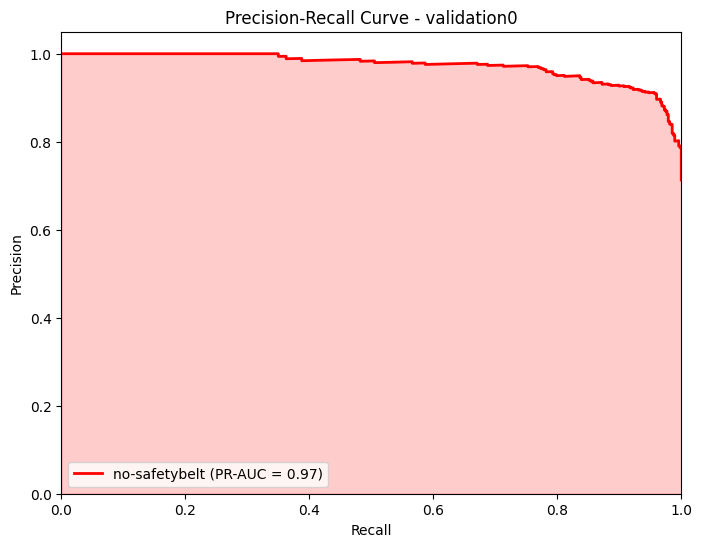

validation: 1
['no-safetybelt'] - PR-AUC: 0.9729
precision@0.90 - Recall: 0.9758 - Threshold: 0.1676
precision@0.95 - Recall: 0.8828 - Threshold: 0.6795 



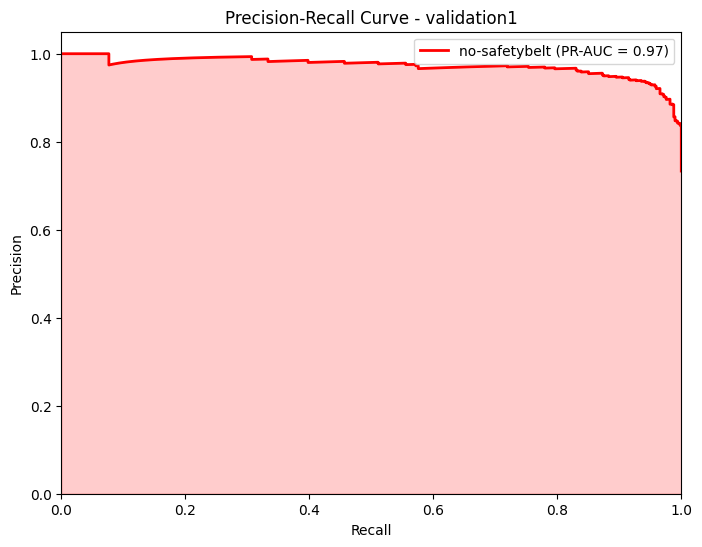

validation: 2
['no-safetybelt'] - PR-AUC: 0.9776
precision@0.90 - Recall: 0.9671 - Threshold: 0.2010
precision@0.95 - Recall: 0.9033 - Threshold: 0.5377 



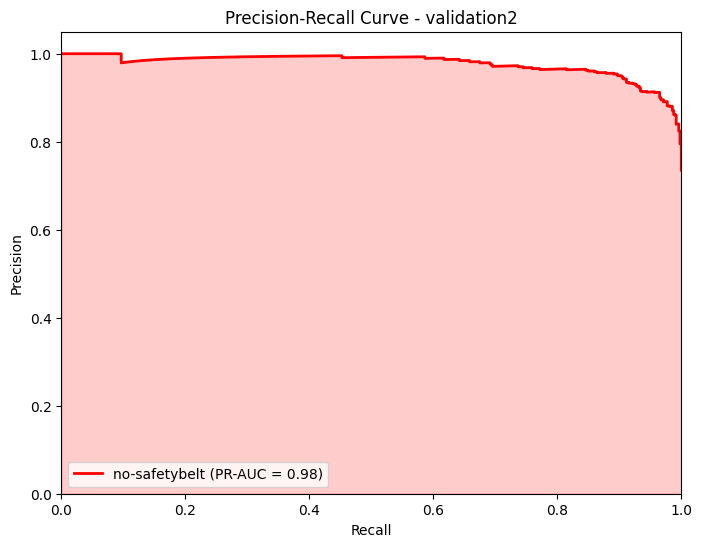

In [16]:
# PR-AUC
average_precision_cv_list = []
result_precision095_cv_list = []
cv_weight = []
threshold_list = []

for num_cv in range(3):
    print(f'validation: {num_cv}')
    plt.figure(figsize=(8, 6))
    for class_num, class_names in enumerate(class_category):
        if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
            continue

        tmp_use_label = [label for label, valid in zip(labels_np, list(valid_all_df['validation'])) if valid == num_cv]
        tmp_use_prob = [prob for prob, valid in zip(prob_np, list(valid_all_df['validation'])) if valid == num_cv]
        use_label = [i for i in tmp_use_label if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_prob = [j for i, j in zip(tmp_use_label, tmp_use_prob) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
        use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
        use_prob = np.array([i[class_num] for i in use_prob])

        cv_weight.append(len(use_prob))

        average_precision = average_precision_score(use_label, use_prob)
        precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
        result_precision090 = [0.9, 0, 0] # precision, recall, threshold で保存
        result_precision095 = [0.95, 0, 0] # precision, recall, threshold で保存
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.9:
                result_precision090 = [p, r, t]
                break
        for p, r, t in zip(precisions, recalls, thresholds):
            if p >= 0.95:
                result_precision095 = [p, r, t]
                break

        average_precision_cv_list.append(average_precision)
        result_precision095_cv_list.append(result_precision095)
        threshold_list.append(result_precision095[2])

        print(f'{class_names} - PR-AUC: {average_precision:.4f}')
        print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
        print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
        color = 'r'
        plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names[0]} (PR-AUC = {average_precision:.2f})')
        plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(f'Precision-Recall Curve - validation{num_cv}')
    plt.legend(loc='best')
    plt.show()

In [17]:
threshold_mean = sum(threshold_list) / 3.0
print(f'Threshold: {threshold_mean}')
print(f'PR-AUC: {sum([ap * weight / sum(cv_weight) for ap, weight in zip(average_precision_cv_list, cv_weight)])}')
print(f'Recall: {sum([ap[1] * weight / sum(cv_weight) for ap, weight in zip(result_precision095_cv_list, cv_weight)])}')
print(f'Precision: {sum([ap[0] * weight / sum(cv_weight) for ap, weight in zip(result_precision095_cv_list, cv_weight)])}')

Threshold: 0.6752666433652242
PR-AUC: 0.9746303429343581
Recall: 0.8741092250280496
Precision: 0.9500713584005354


## テストデータで評価

In [18]:
labels_list = []
prob_list = []
test_df = pred_safetybelt_df[pred_safetybelt_df['validation'] == 999]
test_data = ClassificationDataset(test_df, A_transforms_val)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=False)

# model
for num_cv in range(3):
    model = timm.create_model(huggingface_model_name, pretrained=True, num_classes=len(class_category))
    model.load_state_dict(torch.load(f'{train_result_dir}/{num_cv}/model.pth'))
    model.to(device)

    with torch.no_grad():
        labels_list_cv = []
        prob_list_cv = []
        for data, label in tqdm(test_loader):
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            probs = F.softmax(val_output, dim=1)
            labels_list_cv.append(label.detach().cpu().numpy())
            prob_list_cv.append(probs.detach().cpu().numpy())
        labels_np_cv = np.concatenate(labels_list_cv)
        prob_np_cv = np.concatenate(prob_list_cv)
        labels_list.append(labels_np_cv)
        prob_list.append(prob_np_cv)

labels_np = labels_list[0]
prob_np = (prob_list[0] + prob_list[1] + prob_list[2]) / 3
prob_argmax = np.argmax(prob_np, axis=1)

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

#### confusion matrix - 確率値が最大のクラスをそのまま予測クラスにする

In [19]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, prob in zip(labels_np, prob_argmax):
    confusion_mat[label][prob] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,safetybelt,no-safetybelt
detection-miss,12,0,5
safetybelt,2,0,7
no-safetybelt,9,1,66


#### confusion matrix - 閾値をprecision@0.95にして予測クラスにする

In [20]:
def pred_class_names_precision095(row):
    no_safetybelt_threshold = row['threshold - no-safetybelt']
    if row['no-safetybelt'] >= no_safetybelt_threshold:
        return 'no-safetybelt'
    return row[no_alarm_class_category].idxmax()

In [21]:
# calculate precision@0.95 threshold
threshold_precision095_df_list = []
threshold_precision095_valid_dict = {}
for class_num, class_names in enumerate(class_category):
    if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
        continue
    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    _threshold = 1.0
    for p, t in zip(precisions, thresholds):
        if p >= 0.95:
            _threshold = t
            break
    threshold_precision095_valid_dict[class_names[0]] = _threshold
threshold_precision095_df = pd.DataFrame(
    [[i for i in threshold_precision095_valid_dict.values()] for _ in range(len(test_df))],
    columns=[f'threshold - {i}' for i in threshold_precision095_valid_dict.keys()]
)
prob_df = pd.concat([pd.DataFrame(prob_np, columns=[i[0] for i in class_category]), threshold_precision095_df], axis=1)

In [22]:
test_df['pred_safetybelt_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))

/tmp/ipykernel_2824062/1923474747.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['pred_safetybelt_class'] = list(prob_df.apply(pred_class_names_precision095, axis=1))


In [23]:
confusion_mat = [[0 for i in range(len(class_category))] for j in range(len(class_category))]
for label, pred_name in zip(labels_np, list(test_df['pred_safetybelt_class'])):
    pred_num = [i for i, class_names in enumerate(class_category) if pred_name in class_names][0]
    confusion_mat[label][pred_num] += 1
display(pd.DataFrame(
    confusion_mat, index=[i[0] for i in class_category], columns=[i[0] for i in class_category]
))

,detection-miss,safetybelt,no-safetybelt
detection-miss,16,0,1
safetybelt,7,1,1
no-safetybelt,29,1,46


#### PR-AUC

['no-safetybelt'] - PR-AUC: 0.9496
precision@0.91 - Recall: 0.7763 - Threshold: 0.6786
precision@0.96 - Recall: 0.6053 - Threshold: 0.8319 



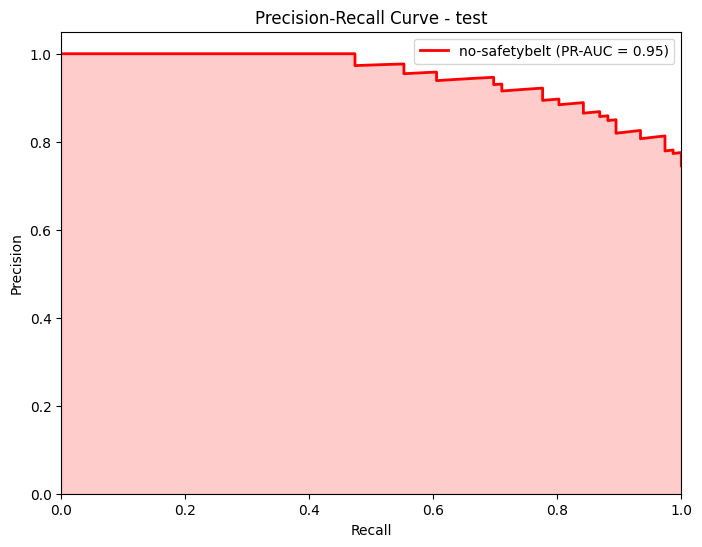

In [24]:
# PR-AUC
plt.figure(figsize=(8, 6))
for class_num, class_names in enumerate(class_category):
    if any([no_alarm_class in class_names for no_alarm_class in no_alarm_class_category]):
        continue

    use_label = [i for i in labels_np if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_prob = [j for i, j in zip(labels_np, prob_np) if i in [j for j in range(len(no_alarm_class_category))] + [class_num]]
    use_label = np.array([1 if i in [class_num] else 0 for i in use_label])
    use_prob = np.array([i[class_num] for i in use_prob])

    average_precision = average_precision_score(use_label, use_prob)
    precisions, recalls, thresholds = precision_recall_curve(use_label, use_prob)
    result_precision090 = [0.9, 0, 0] # precision, recall, threshold で保存
    result_precision095 = [0.95, 0, 0] # precision, recall, threshold で保存
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.9:
            result_precision090 = [p, r, t]
            break
    for p, r, t in zip(precisions, recalls, thresholds):
        if p >= 0.95:
            result_precision095 = [p, r, t]
            break

    print(f'{class_names} - PR-AUC: {average_precision:.4f}')
    print(f'precision@{result_precision090[0]:.2f} - Recall: {result_precision090[1]:.4f} - Threshold: {result_precision090[2]:.4f}')
    print(f'precision@{result_precision095[0]:.2f} - Recall: {result_precision095[1]:.4f} - Threshold: {result_precision095[2]:.4f} \n')
    color = 'r'
    plt.plot(recalls, precisions, color=color, lw=2, label=f'{class_names[0]} (PR-AUC = {average_precision:.2f})')
    plt.fill_between(recalls, precisions, step='post', alpha=0.2, color=color)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(f'Precision-Recall Curve - test')
plt.legend(loc='best')
plt.show()

In [25]:
pd.concat([valid_all_df, test_df]).to_csv(f'{result_dir}/pred_safetybelt_class-{pattern_date}.csv', index=False)